<h1 align="center">Text Summarization Using BART and T5 Models</h1>

## Table of Contents

>>[Set Up Environment](#scrollTo=7kRB5arLnOcg)

>>[Import Libraries](#scrollTo=OkCLSmfFnShw)

>>[Define Constants](#scrollTo=ARUdJzqKngl1)

>>[Experiment Design](#scrollTo=j2lfZvgLmPpW)

>>[Load CNN/Daily Mail Dataset](#scrollTo=_k0jITnCnW5d)

>>[Select a Pre-trained Model](#scrollTo=AKhT9xphaDJC)

>>[Load a Pre-trained Model](#scrollTo=03W21c-wnpcK)

>>[Text Preprocessing](#scrollTo=ZIx9E7fJzDYf)

>>[Pre-training Evaluation](#scrollTo=ChnNqDqQd-wW)

>>[Model Fine-tuning](#scrollTo=wzQftdE1fYah)

>>>>[10.1 Hyperparameter Settings](#scrollTo=MGiUPouMwSPe)

>>>>[10.2 Advanced Fine-tuning Techniques](#scrollTo=YBHuCodTwiWr)

>>>>[10.3 Findings During Training](#scrollTo=dH1yGVS9wvhW)

>>>>[10.4 Regularization Methods](#scrollTo=oJih_-CXw5YB)

>>[Performance Evaluation](#scrollTo=3-A7c69OoxZF)

>>[Build Text Summarization Pipeline](#scrollTo=z75PRhhmgUgB)

>>[Best Practices](#scrollTo=x94DJik0zvx9)



## 1. Set Up Environment

In [1]:
!pip install torch datasets transformers rouge-score

In [2]:
! pip install -U accelerate
! pip install -U transformers

## 2. Import Libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import fileinput
import sys
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
import datasets
from datasets import load_dataset, load_metric, Dataset
from datasets import load_from_disk
from transformers import BartTokenizer, BartForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration
from transformers import Trainer, TrainingArguments, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import pipeline

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import Counter
from wordcloud import WordCloud
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

## 3. Define Constants

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
data_dir = "./"

In [9]:
USE_ADVANCES_TECH = False

In [10]:
HYPERS = {
    "BART-BASE": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },

    "BART-LARGE": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },

    "BART-LARGE-CNN": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },

    "T5-SMALL": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },

    "T5-BASE": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },

    "T5-LARGE": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 512,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 50,
        "SUMMARY_ARTICLE_MAX_LENGTH": 512,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 50,
        "SUMMARY_HIGHLIGHT_BEAM": 2,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 2,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 2,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 2,
        "TRAIN_GENERATION_MAX_LENGTH": 50,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 50,
        "PIPELINE_MIN_LENGTH": 40,
    },

    "BART-LARGE-CNN-FREEZE": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },

    "BART-LARGE-CNN-DISCRIM": {
        "PREPROCESSING_ARTICLE_MAX_LENGTH": 1024,
        "PREPROCESSING_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_ARTICLE_MAX_LENGTH": 1024,
        "SUMMARY_HIGHLIGHT_MAX_LENGTH": 150,
        "SUMMARY_HIGHLIGHT_BEAM": 4,
        "SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES": 1,
        "SUMMARY_MAP_BATCH_SIZE": 8,
        "TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE": 4,
        "TRAIN_PER_DEVICE_EVAL_BATCH_SIZE": 4,
        "TRAIN_GENERATION_MAX_LENGTH": 150,
        "TRAIN_GENERATION_NUM_BEAMS": 2,
        "PIPELINE_MAX_LENGTH": 150,
        "PIPELINE_MIN_LENGTH": 50,
    },
}

## 4. Experiment Design

Our experiments contain 6 main stages.

(1) Data Preparation

(2) Data Preprocessing

(3) Pre-training Evaluation: Evaluate the pre-trained models before fine-tuning them on the dataset to set baselines for further experiments.

(4) Model Fine-tune: Fine-tune the models on the CNN/Daily Mail dataset. I use the validation set for hyperparameter tuning.

(5) Performance Evaluation: Evaluate the performance of different models and compare their performance with themselves before fine-tuning.

(6) Inference: If we are not satisfied with the results, we train the models again with a different set of training parameters. Otherwise, we take the trained model and build a text summarization pipeline. I test the summarization ability of this pipeline by randomly finding a piece of the latest news on the internet and feeding it into the pipeline.

(7) Finally, I conduct the qualitative evaluation of the summary generated by the pipeline.

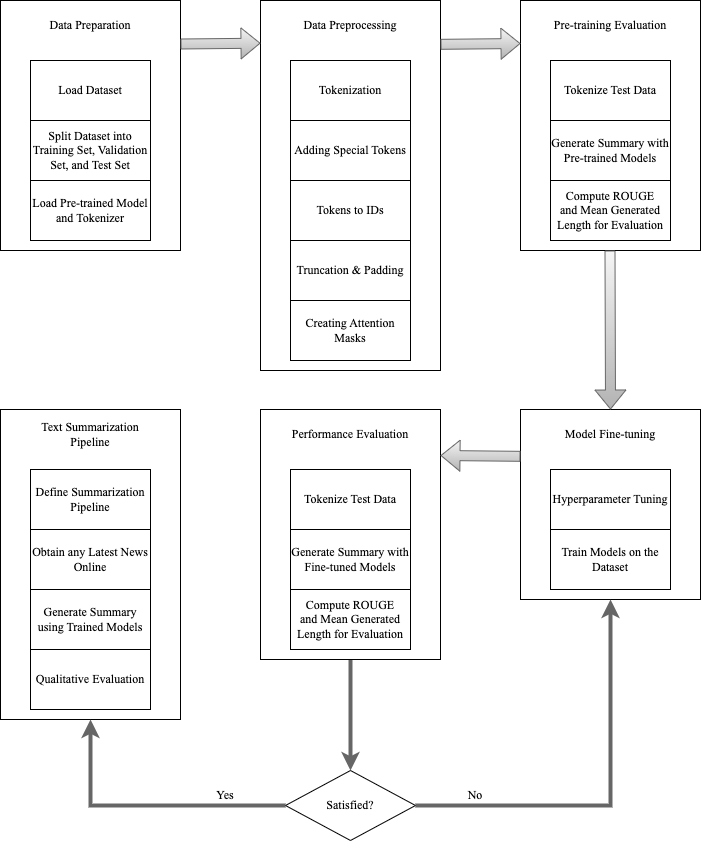


## 5. Load CNN/Daily Mail Dataset

In [11]:
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[0:300]")

In [12]:
# Split the dataset into training set, validation set, and test set
train_dataset, test_dataset= dataset.train_test_split(test_size=0.05).values()
train_dataset, validation_dataset= train_dataset.train_test_split(test_size=0.05).values()

dataset = datasets.DatasetDict({"train":train_dataset, "validation": validation_dataset,"test":test_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 270
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 15
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 15
    })
})

## 6. Select a Pre-trained Model

In [ ]:
MODEL_SELECTED = "BART-LARGE-CNN"

model_save_path = "./" + str(MODEL_SELECTED)

## 7. Load a Pre-trained Model

In [14]:
if MODEL_SELECTED == "BART-BASE":
    # Initialize a tokenizer
    pretrained_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
    # Initialize a model
    pretrained_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)
elif MODEL_SELECTED == "BART-LARGE":
    # Initialize a tokenizer
    pretrained_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
    # Initialize a model
    pretrained_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large").to(device)
elif MODEL_SELECTED == "BART-LARGE-CNN":
    # Initialize a tokenizer
    pretrained_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
    # Initialize a model
    pretrained_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to(device)
elif MODEL_SELECTED == "T5-SMALL":
    # Initialize a tokenizer
    pretrained_tokenizer = T5Tokenizer.from_pretrained("t5-small")
    # Initialize a model
    pretrained_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
elif MODEL_SELECTED == "T5-BASE":
    # Initialize a tokenizer
    pretrained_tokenizer = T5Tokenizer.from_pretrained("t5-base")
    # Initialize a model
    pretrained_model = T5ForConditionalGeneration.from_pretrained("t5-base").to(device)
elif MODEL_SELECTED == "T5-LARGE":
    # Initialize a tokenizer
    pretrained_tokenizer = T5Tokenizer.from_pretrained("t5-large")
    # Initialize a model
    pretrained_model = T5ForConditionalGeneration.from_pretrained("t5-large").to(device)
elif MODEL_SELECTED == "BART-LARGE-CNN-FREEZE":
    # Initialize a tokenizer
    pretrained_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
    # Initialize a model
    pretrained_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to(device)
elif MODEL_SELECTED == "BART-LARGE-CNN-DISCRIM":
    # Initialize a tokenizer
    pretrained_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
    # Initialize a model
    pretrained_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to(device)
else:
    raise ValueError("Please input correct model name")

## 8. Text Preprocessing

(1) Tokenization: Divide the input text into small tokens.

(2) Adding Special Tokens: Help the model to interpret the structure of the input text and label text by adding special tokens to the original text.

(3) Tokens to IDs: Convert words or characters to the unique IDs in the tokenizers' vocabulary. These IDs are used as the input for LLMs.

(4) Truncation: Ensure that all long input text is shortened to a pre-defined maximum length.

(5) Padding: Ensures that all short input text is extended to a pre-defined maximum length.

(6) Creating Attention Masks: A list of binary masks that differentiates real word tokens (represented as 1) and padding tokens (represented as 0).

In [15]:
def text_preprocessing(samples, model_name):
    if model_name in ["BART-BASE", "BART-LARGE", "BART-LARGE-CNN", "BART-LARGE-CNN-FREEZE", "BART-LARGE-CNN-DISCRIM"]:
        inputs = [art for art in samples["article"]]
        model_inputs = pretrained_tokenizer(inputs,
                                            max_length=HYPERS[model_name]["PREPROCESSING_ARTICLE_MAX_LENGTH"],
                                            truncation=True,
                                            padding="max_length")
        with pretrained_tokenizer.as_target_tokenizer():
            labels = pretrained_tokenizer(samples["highlights"],
                                          max_length=HYPERS[model_name]["PREPROCESSING_HIGHLIGHT_MAX_LENGTH"],
                                          truncation=True,
                                          padding="max_length")
        model_inputs["labels"] = labels["input_ids"]
    elif model_name in ["T5-SMALL", "T5-BASE", "T5-LARGE"]:
        inputs = ["summarize: " + art for art in samples["article"]]
        model_inputs = pretrained_tokenizer(inputs,
                                            max_length=HYPERS[model_name]["PREPROCESSING_ARTICLE_MAX_LENGTH"],
                                            truncation=True,
                                            padding="max_length")
        with pretrained_tokenizer.as_target_tokenizer():
            labels = pretrained_tokenizer(samples["highlights"],
                                          max_length=HYPERS[model_name]["PREPROCESSING_HIGHLIGHT_MAX_LENGTH"],
                                          truncation=True,
                                          padding="max_length")
        model_inputs["labels"] = labels["input_ids"]
    else:
        raise ValueError("Please input correct model name")

    return model_inputs

In [16]:
tokenized_dataset = dataset.map(text_preprocessing, batched=True, fn_kwargs={"model_name": MODEL_SELECTED})
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/270 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

## 9. Pre-training Evaluation

I evaluate these models from both quantitative and qualitative sides.

(1) For quantitative evaluation:

- ROUGE (Recall-Oriented Understudy for Gisting Evaluation)

- Mean Generated Length

- Average Run Time.

(2) For qualitative evaluation:

- Conduct human evaluation as it is the main goal for most of the NLP tasks.

(3) In the experiment, we focus on the F1-Scores of ROUGE-Lsum scores.

- ROUGE-Lsum measures the longest common subsequence between the generated text and the target highlight with a length penalty term, forcing the model to choose concise generation.

- F1-Scores are balanced factors of recalls and precisions. Since we focus on text summarization, we aim to generate short and informative summaries
containing key information from the original articles. Therefore, we need to find a balance between capturing relevant information, which is recall, and dropping duplicate context, which is precision.

F1-Scores of ROUGE scores provide a good estimation of a combination of
recall and precision, which is well-suited for our purpose.

(4) The higher the ROUGE scores, the better capturing and more concise summarization quality.

In [17]:
def text_summarization(batch, model_name):
    if model_name in ["BART-BASE", "BART-LARGE", "BART-LARGE-CNN", "BART-LARGE-CNN-FREEZE", "BART-LARGE-CNN-DISCRIM"]:
        inputs = [art for art in batch["article"]]
        model_inputs = pretrained_tokenizer(inputs,
                                            max_length=HYPERS[model_name]["SUMMARY_ARTICLE_MAX_LENGTH"],
                                            truncation=True,
                                            padding="max_length",
                                            return_tensors="pt")
        # Move to GPU
        model_inputs = {key: value.to(device) for key, value in model_inputs.items()}
        summary_ids = pretrained_model.generate(model_inputs["input_ids"],
                                                num_beams=HYPERS[model_name]["SUMMARY_HIGHLIGHT_BEAM"],
                                                max_length=HYPERS[model_name]["SUMMARY_HIGHLIGHT_MAX_LENGTH"],
                                                early_stopping=True,
                                                num_return_sequences=HYPERS[model_name]["SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES"])
        batch["summary"] = pretrained_tokenizer.batch_decode(summary_ids,
                                                             skip_special_tokens=True,
                                                             clean_up_tokenization_spaces=False)

        # Delete the data on GPU
        del model_inputs
        # Clear GPU cache
        torch.cuda.empty_cache()

    elif model_name in ["T5-SMALL", "T5-BASE", "T5-LARGE"]:
        inputs = ["summarize: " + art for art in batch["article"]]
        model_inputs = pretrained_tokenizer(inputs,
                                            max_length=HYPERS[model_name]["SUMMARY_ARTICLE_MAX_LENGTH"],
                                            truncation=True,
                                            padding="max_length",
                                            return_tensors="pt")
        # Move to GPU
        model_inputs = {key: value.to(device) for key, value in model_inputs.items()}
        summary_ids = pretrained_model.generate(model_inputs["input_ids"],
                                                num_beams=HYPERS[model_name]["SUMMARY_HIGHLIGHT_BEAM"],
                                                max_length=HYPERS[model_name]["SUMMARY_HIGHLIGHT_MAX_LENGTH"],
                                                early_stopping=True,
                                                num_return_sequences=HYPERS[model_name]["SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES"])
        batch["summary"] = pretrained_tokenizer.batch_decode(summary_ids,
                                                             skip_special_tokens=True,
                                                             clean_up_tokenization_spaces=False)

        # Delete the data on GPU
        del model_inputs
        # Clear GPU cache
        torch.cuda.empty_cache()

    else:
        raise ValueError("Please input correct model name")

    return batch

In [18]:
summaries = dataset["test"].map(text_summarization, batched=True, batch_size=HYPERS[MODEL_SELECTED]["SUMMARY_MAP_BATCH_SIZE"], fn_kwargs={"model_name": MODEL_SELECTED})

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

In [19]:
def compute_metrics(pred):
    rouge = load_metric("rouge")

    references = pred["highlights"]
    predictions = pred["summary"]

    # Compute Rouge scores
    result = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

    # Compute the mid F1 scores based on the results of all metrics
    output_result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    # Compute average length of the generated text
    prediction_lens = [len(pred.split()) for pred in predictions]
    output_result["gen_len"] = np.mean(prediction_lens)

    return pd.DataFrame.from_dict([output_result])

metrics = compute_metrics(summaries)

with pd.option_context("display.max_colwidth", None):
    metrics = metrics.rename(columns={"rouge1": "ROUGE1", "rouge2": "ROUGE2", "rougeL": "ROUGEL", "rougeLsum": "ROUGELsum", "gen_len": "Mean Generated Length"})
    styled_metrics = metrics.style.format()
    display(styled_metrics.hide())

ROUGE1,ROUGE2,ROUGEL,ROUGELsum,Mean Generated Length
39.866949,16.586604,27.545879,33.401832,49.866667


## 10. Model Fine-tuning

(1) Hyperparameter Tuning: Try different combinations of hyperparameters during the training process and check the performance on the validation set.

(2) Training Models on the CNN/Daily Mail Dataset: Train models for a few epochs with extremely small learning rates. We want the model to converge on this new dataset while avoiding overfitting.

#### 10.1 Hyperparameter Settings

- The hyperparameter settings are as follows.

- Since the T5-LARGE model contains over 770 million parameters, limited by computational resources, I design a set of parameters specifically for this model.

| Hyperparameters | Other Models | T5-LARGE |
| ---  | ---           | ---             |
|Preprocessing Article Max Length | 1024  | 512 |
|Preprocessing Highlight Max Length | 150  | 50 |
|Train Per Device Train Batch Size | 4 | 2 |
|Train Per Device Eval Batch Size | 4 | 2 |
|Train Generation Max Length | 150 | 50 |
|Train Generation Num Beams | 2 | 2 |
|Learning Rate | 3e-5 | 3e-5 |
|Warmup Steps | 500 | 500 |
|Weight Decay | 0.01 | 0.01 |
|Epoch | 3 | 3 |
|Evaluation Steps During Training | 20 | 20 |
|Logging Steps During Training | 20 | 20 |
|Summary Article Max Length | 1024 | 512 |
|Summary Highlight Max Length | 150 | 50 |
|Summary Highlight Beam | 150 | 2 |
|Summary Highlight Num Return Sequences | 1 | 1 |
|Summary Map Batch Size | 8 | 2 |
|Pipeline Max Length | 150 | 50 |
|Pipeline Min Length | 50 | 40 |

In [20]:
if not USE_ADVANCES_TECH:
    seq2seq_training_args = Seq2SeqTrainingArguments(
        output_dir=model_save_path,
        # Evaluate after every eval steps
        evaluation_strategy="steps",
        eval_steps=20,
        num_train_epochs=3,
        # Batch size for training
        per_device_train_batch_size=HYPERS[MODEL_SELECTED]["TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE"],
        # Batch size for validation
        per_device_eval_batch_size=HYPERS[MODEL_SELECTED]["TRAIN_PER_DEVICE_EVAL_BATCH_SIZE"],
        warmup_steps=500,
        weight_decay=0.01,
        # Output for TensorBoard logs
        logging_dir='./logs',
        # Log every 20 steps
        logging_steps=20,
        # Generate predicted text sequences during evaluation. The generated text are compared against the target highlight.
        predict_with_generate=True,
        learning_rate=3e-5,
        # Max length of text generation during evaluation.
        generation_max_length=HYPERS[MODEL_SELECTED]["TRAIN_GENERATION_MAX_LENGTH"],
        # Number of beams for beam search during evaluation
        generation_num_beams=HYPERS[MODEL_SELECTED]["TRAIN_GENERATION_NUM_BEAMS"],
    )

    seq2seq_trainer = Seq2SeqTrainer(
        model=pretrained_model,
        args=seq2seq_training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
    )

    seq2seq_trainer.train()

Step,Training Loss,Validation Loss
20,8.125000,7.641587
40,7.108200,6.246601
60,5.218000,3.330870
80,2.783000,1.632233
100,1.559800,1.068429
120,1.104000,0.798834
140,0.817300,0.674911
160,0.609900,0.611107
180,0.579800,0.568184
200,0.466900,0.553135


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


#### 10.2 Advanced Fine-tuning Techniques

In this project, I also investigate the effectiveness of two advanced fine-tuning techniques.

(1) Layer Freezing: Layer Freezing freezes the early layers of the model and only fine-tunes the later layers.  Layer Freezing works well when we have a small dataset. This method is able to speed up the training process and mitigate overfitting.

(2) Discriminative Fine-Tuning: Applying different learning rates to the model is beneficial when we want to keep some layers in the model stable. Early layers are trained using a lower learning rate, and later layers are trained using a higher learning rate. As a result, the later layers receive more momentum to change and fit the new dataset.

In [21]:
def freeze_bart_layers(model, num_layers_to_freeze):
    # Freeze encoder layers
    for i in range(num_layers_to_freeze):
        for param in model.model.encoder.layers[i].parameters():
            param.requires_grad = False

    # Freeze decoder layers
    for i in range(num_layers_to_freeze):
        for param in model.model.decoder.layers[i].parameters():
            param.requires_grad = False

if USE_ADVANCES_TECH:
    if MODEL_SELECTED == "BART-LARGE-CNN-FREEZE":
        freeze_bart_layers(pretrained_model, num_layers_to_freeze=6)
    elif MODEL_SELECTED == "BART-LARGE-CNN-DISCRIM":
        pass
    else:
        raise ValueError("Please input correct model name")

In [22]:
def get_optimizer_params(pretrained_model, learning_rate_early, learning_rate_later):
    optimizer_grouped_parameters = [
        {"params": pretrained_model.model.encoder.layers[:6].parameters(), "lr": learning_rate_early},
        {"params": pretrained_model.model.encoder.layers[6:].parameters(), "lr": learning_rate_later},
        {"params": pretrained_model.model.decoder.layers[:6].parameters(), "lr": learning_rate_early},
        {"params": pretrained_model.model.decoder.layers[6:].parameters(), "lr": learning_rate_later}
    ]

    return optimizer_grouped_parameters

if USE_ADVANCES_TECH:
    if MODEL_SELECTED == "BART-LARGE-CNN-FREEZE":
        pass
    elif MODEL_SELECTED == "BART-LARGE-CNN-DISCRIM":
        learning_rate_early = 1e-5
        learning_rate_later = 3e-5
    else:
        raise ValueError("Please input correct model name")

In [23]:
if USE_ADVANCES_TECH:
    seq2seq_training_args = Seq2SeqTrainingArguments(
        output_dir=model_save_path,
        # Evaluate after every eval steps
        evaluation_strategy="steps",
        eval_steps=20,
        num_train_epochs=3,
        # Batch size for training
        per_device_train_batch_size=HYPERS[MODEL_SELECTED]["TRAIN_PER_DEVICE_TRAIN_BATCH_SIZE"],
        # Batch size for validation
        per_device_eval_batch_size=HYPERS[MODEL_SELECTED]["TRAIN_PER_DEVICE_EVAL_BATCH_SIZE"],
        warmup_steps=500,
        weight_decay=0.01,
        # Output for TensorBoard logs
        logging_dir='./logs',
        # Log every 20 steps
        logging_steps=20,
        # Generate predicted text sequences during evaluation. The generated text are compared against the target highlight.
        predict_with_generate=True,
        learning_rate=3e-5,
        # Max length of text generation during evaluation.
        generation_max_length=HYPERS[MODEL_SELECTED]["TRAIN_GENERATION_MAX_LENGTH"],
        # Number of beams for beam search during evaluation
        generation_num_beams=HYPERS[MODEL_SELECTED]["TRAIN_GENERATION_NUM_BEAMS"],
    )

    seq2seq_trainer = Seq2SeqTrainer(
        model=pretrained_model,
        args=seq2seq_training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        optimizers=(None, None)
    )

    # Custom optimizer creation function
    def custom_create_optimizer_and_scheduler(trainer, num_training_steps):
        optimizer_params = get_optimizer_params(pretrained_model, learning_rate_early, learning_rate_later)
        trainer.optimizer = torch.optim.AdamW(optimizer_params)
        trainer.lr_scheduler = trainer.create_scheduler(num_training_steps=num_training_steps, optimizer=trainer.optimizer)

    if MODEL_SELECTED == "BART-LARGE-CNN-FREEZE":
        pass
    elif MODEL_SELECTED == "BART-LARGE-CNN-DISCRIM":
        # Override the optimizer creation method
        seq2seq_trainer.create_optimizer_and_scheduler = lambda num_training_steps: custom_create_optimizer_and_scheduler(seq2seq_trainer, num_training_steps)
    else:
        raise ValueError("Please input correct model name")

    seq2seq_trainer.train()

#### 10.3 Findings During Training

- Learning Rate: I also experimented with a learning rate of 1e-5. The results were worse than using a learning rate of 3e-5. Smaller learning rates slightly update weights and need more training time.

- Batch Size: Limited by computational resources, batch sizes cannot be too large.

- Beam Search: Beam number significantly affects the training and generation speed. Setting a higher beam number can improve the quality of summaries at the cost of higher computational resources demand.

- Generation Length: The maximum text length for training and generation should remain consistent.

#### 10.4 Regularization Methods

Since these models generally contain millions of parameters and we are limited by the size of the dataset and training time, we need to add regularizations during the training process to prevent the models from overfitting.

- Warmup Steps: I enable warmup steps during training. In the warmup stage, the learning rate starts from a very small value and gradually increases to the pre-defined value. Warmup can stabilize the training process and smooth gradient updates in the early training stage.

- Weight Decay: Weight decay is a regularization method for stabilizing the training process by adding an L2-regularization term to the loss function. Weight decay prevents the model from overfitting.

- Early Stopping: While generating new summaries, I am using beam search with the number of beams greater than 1. However, we do not want to search for all possible sequences in the generation process. We only want a few best sequences. The early stopping parameter controls when to stop the generation process if the model has found the required number of sequences.

## 11. Performance Evaluation

In [24]:
def text_summarization(batch, model_name):
    if model_name in ["BART-BASE", "BART-LARGE", "BART-LARGE-CNN", "BART-LARGE-CNN-FREEZE", "BART-LARGE-CNN-DISCRIM"]:
        inputs = [art for art in batch["article"]]
        model_inputs = pretrained_tokenizer(inputs,
                                            max_length=HYPERS[model_name]["SUMMARY_ARTICLE_MAX_LENGTH"],
                                            truncation=True,
                                            padding="max_length",
                                            return_tensors="pt")
        # Move to GPU
        model_inputs = {key: value.to(device) for key, value in model_inputs.items()}
        summary_ids = pretrained_model.generate(model_inputs["input_ids"],
                                                num_beams=HYPERS[model_name]["SUMMARY_HIGHLIGHT_BEAM"],
                                                max_length=HYPERS[model_name]["SUMMARY_HIGHLIGHT_MAX_LENGTH"],
                                                early_stopping=True,
                                                num_return_sequences=HYPERS[model_name]["SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES"])
        batch["summary"] = pretrained_tokenizer.batch_decode(summary_ids,
                                                             skip_special_tokens=True,
                                                             clean_up_tokenization_spaces=False)

        # Delete the data on GPU
        del model_inputs
        # Clear GPU cache
        torch.cuda.empty_cache()

    elif model_name in ["T5-SMALL", "T5-BASE", "T5-LARGE"]:
        inputs = ["summarize: " + art for art in batch["article"]]
        model_inputs = pretrained_tokenizer(inputs,
                                            max_length=HYPERS[model_name]["SUMMARY_ARTICLE_MAX_LENGTH"],
                                            truncation=True,
                                            padding="max_length",
                                            return_tensors="pt")
        # Move to GPU
        model_inputs = {key: value.to(device) for key, value in model_inputs.items()}
        summary_ids = pretrained_model.generate(model_inputs["input_ids"],
                                                num_beams=HYPERS[model_name]["SUMMARY_HIGHLIGHT_BEAM"],
                                                max_length=HYPERS[model_name]["SUMMARY_HIGHLIGHT_MAX_LENGTH"],
                                                early_stopping=True,
                                                num_return_sequences=HYPERS[model_name]["SUMMARY_HIGHLIGHT_NUM_RETURN_SEQUENCES"])
        batch["summary"] = pretrained_tokenizer.batch_decode(summary_ids,
                                                             skip_special_tokens=True,
                                                             clean_up_tokenization_spaces=False)

        # Delete the data on GPU
        del model_inputs
        # Clear GPU cache
        torch.cuda.empty_cache()

    else:
        raise ValueError("Please input correct model name")

    return batch

In [25]:
summaries = dataset["test"].map(text_summarization, batched=True, batch_size=HYPERS[MODEL_SELECTED]["SUMMARY_MAP_BATCH_SIZE"], fn_kwargs={"model_name": MODEL_SELECTED})

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

In [26]:
def compute_metrics(pred):
    rouge = load_metric("rouge")

    references = pred["highlights"]
    predictions = pred["summary"]

    # Compute Rouge scores
    result = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

    # Compute the mid F1 scores based on the results of all metrics
    output_result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    # Compute average length of the generated text
    prediction_lens = [len(pred.split()) for pred in predictions]
    output_result["gen_len"] = np.mean(prediction_lens)

    return pd.DataFrame.from_dict([output_result])

metrics = compute_metrics(summaries)

with pd.option_context("display.max_colwidth", None):
    metrics = metrics.rename(columns={"rouge1": "ROUGE1", "rouge2": "ROUGE2", "rougeL": "ROUGEL", "rougeLsum": "ROUGELsum", "gen_len": "Mean Generated Length"})
    styled_metrics = metrics.style.format()
    display(styled_metrics.hide())

ROUGE1,ROUGE2,ROUGEL,ROUGELsum,Mean Generated Length
40.880113,17.237597,29.510233,38.605159,45.933333


## 12. Build Text Summarization Pipeline

During inference, we generate summaries for new articles (up-to-date news) using the fine-tuned models. This step is to test the results of our fine-tuned models and give us an intuitive understanding of how models work.

In [27]:
# Summarization pipeline
summarizer = pipeline("summarization",
                      model=pretrained_model,
                      tokenizer=pretrained_tokenizer,
                      device=device)

# Example text to summarize
my_text = "The researchers developed a specialized microscopy technique for imaging multiple sides of the fossil antennae to better examine the ants’ sensilla — tiny projections that detect environmental cues. They compared the fossil ants’ suite of sensilla to those of six modern ant species. G. gracilis had two types of sensilla that are known only in ants. These organs are used for identifying nestmates and detecting their alarm pheromones, which notify other ants of threats to the colony. Together, these unique sensilla help ants live together and defend the colony as a single unit. Today, many ant species create massive colonies thousands to millions strong, but the researchers argue that the fossil record suggests that the earliest ants lived in very small colonies of a few dozen nestmates. Despite this, “we can consider that ants lived in a highly advanced social system even in their early evolutionary stages,” Taniguchi says. The new findings suggest that tens of millions of years before they became an ecological force in ecosystems around the world, ants may have been marching together."

# Generate summary
my_summary = summarizer(my_text,
                        max_length=HYPERS[MODEL_SELECTED]["PIPELINE_MAX_LENGTH"],
                        min_length=HYPERS[MODEL_SELECTED]["PIPELINE_MIN_LENGTH"],
                        do_sample=False)

my_results = pd.DataFrame({"Summary": my_summary, "Article": my_text})

with pd.option_context("display.max_colwidth", None):
    styled_my_results = my_results.style.format()
    display(styled_my_results.hide())

Summary,Article
"{'summary_text': 'Researchers developed a specialized microscopy technique for imaging multiple sides of the fossil antennae. They compared the fossil ants’ suite of sensilla to those of six modern ant species. The findings suggest that tens of millions of years before they became an ecological force in ecosystems, ants may have been marching together.'}","The researchers developed a specialized microscopy technique for imaging multiple sides of the fossil antennae to better examine the ants’ sensilla — tiny projections that detect environmental cues. They compared the fossil ants’ suite of sensilla to those of six modern ant species. G. gracilis had two types of sensilla that are known only in ants. These organs are used for identifying nestmates and detecting their alarm pheromones, which notify other ants of threats to the colony. Together, these unique sensilla help ants live together and defend the colony as a single unit. Today, many ant species create massive colonies thousands to millions strong, but the researchers argue that the fossil record suggests that the earliest ants lived in very small colonies of a few dozen nestmates. Despite this, “we can consider that ants lived in a highly advanced social system even in their early evolutionary stages,” Taniguchi says. The new findings suggest that tens of millions of years before they became an ecological force in ecosystems around the world, ants may have been marching together."


## 13. Best Practices

(1) Fine-tuning is an essential step for training LLMs on a specific task. It increases the performance of LLMs on the selected task with an acceptable amount of training time and computational resources.

(2) Hyperparameter tuning is crucial for fine-tuning LLMs with limited resources. Many hyperparameters have huge impacts on the model training time and memory required. Sometimes we need to find a balance between the amount of training resources required and the fine-tuned model's performance.

(3) Training time depends on the following factors.

- Model Size: Larger models need more time to train.

- Batch Size: Larger batch sizes reduce the training time.

- Number of Epochs: The number of epochs is the main factor determining the training time.

- Sequence Length: Longer input sequences require more training time.

(4) The amount of memory required depends on the following factors.
- Batch Size: Larger batch sizes increase the memory used.

- Generated Sequence Length: The longer the generated sequences are, the more memory they occupy.

(5) Different tasks have their corresponding evaluation metrics. These metrics are designed for certain tasks and can better reveal their performance. Human evaluation is another key measure to evaluate the model's performance in the NLP domain as human interpretation is the ultimate goal of any NLP tasks.